# 미니 경진대회 - 배터리 수명 예측

본 파일은 경연대회에 참가하시는 모든 참가자 분들에게 제공되는 기본 코드입니다. 따라서 **본인이 원하는 대로 자유롭게 수정하면서 경진대회를 진행하세요.** 

본 코드는 플랫폼 상에서 데이터를 불러오는 방법부터 간단한 전처리 및 머신러닝 모델링 과정을 소개하고 있습니다. 나아가서 작성한 코드의 결과를 플랫폼 상에서 바로 채점하기 위한 과정까지 확인해볼 수 있습니다.

In [1]:
# 만약 라이브러리를 설치하는 명령어가 있다면, 이 셀에 몰아두는 것을 권장합니다.
!pip install --upgrade pip

Defaulting to user installation because normal site-packages is not writeable


In [2]:
# 예시 코드에 필요한 라이브러리를 불러옵니다.
import os

import pandas as pd
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVR


data_dir = "/mnt/elice/dataset"

## 데이터 불러오기

학습 데이터와 테스트 데이터를 불러옵니다.

In [3]:
train_df = pd.read_csv(os.path.join(data_dir, "train_data.csv"), index_col="Cell_ID")
test_df = pd.read_csv(os.path.join(data_dir, "test_data.csv"), index_col="Cell_ID")

# 테스트 데이터도 학습용 데이터와 같이 'Lifetime' 컬럼이 있지만 값은 비어 있습니다.
# Lifetime 컬럼을 제거해 줍니다.
test_x = test_df.drop(["Lifetime"], axis=1)
train_x = train_df.iloc[:, :-1]
train_y = train_df.iloc[:, -1]

불러온 학습 데이터의 일부를 확인해봅시다.

In [4]:
# 학습 데이터 컬럼의 종류를 확인했습니다.
train_df.columns

Index(['CV_time_0', 'CV_time_3', 'Chg_C-rate', 'Dchg_C-rate', 'DoD', 'Q_ini',
       'Q_ini_V_high', 'Q_ini_V_low', 'Q_ini_V_mid', 'Q_initial', 'avg_stress',
       'capacity_fade_3_0', 'chg_stress', 'dchg_stress', 'delta_CV_time_3_0',
       'delta_Q_DVA1', 'delta_Q_DVA2', 'delta_Q_DVA3', 'delta_Q_DVA4',
       'kurt_deltaQ', 'mean_deltaQ_dchg_3_0', 'mean_dqdv_dchg_3_0',
       'mean_dqdv_dchg_high_3_0', 'mean_dqdv_dchg_low_3_0',
       'mean_dqdv_dchg_mid_3_0', 'min_deltaQ', 'multi_stress', 'skew_deltaQ',
       'var_deltaQ', 'var_deltaQ_dchg_3_0', 'var_dqdv_dchg_3_0',
       'var_dqdv_dchg_high_3_0', 'var_dqdv_dchg_low_3_0',
       'var_dqdv_dchg_mid_3_0', 'Lifetime'],
      dtype='object')

In [5]:
# 학습용 데이터의 값의 형태를 일부 확인했습니다.
train_df.head()

,CV_time_0,CV_time_3,Chg_C-rate,Dchg_C-rate,DoD,Q_ini,Q_ini_V_high,Q_ini_V_low,Q_ini_V_mid,Q_initial,...,min_deltaQ,multi_stress,skew_deltaQ,var_deltaQ,var_deltaQ_dchg_3_0,var_dqdv_dchg_3_0,var_dqdv_dchg_high_3_0,var_dqdv_dchg_low_3_0,var_dqdv_dchg_mid_3_0,Lifetime
Cell_ID,,,,,,,,,,,,,,,,,,,,,
1031U,1076.0,859.0,1.8,0.6,0.499119,0.284567,-0.088571,-0.080993,-0.115620,0.284567,...,-0.013893,0.518700,0.934353,0.000042,0.000042,0.001657,0.002272,0.000155,0.002816,14.425
1101F,1090.0,748.0,0.5,0.5,0.976741,0.285810,-0.090005,-0.078695,-0.117403,0.285810,...,-0.010924,0.488371,0.960777,0.000036,0.000036,0.001955,0.002748,0.000290,0.002246,16.805
1138K,1048.0,754.0,1.4,0.5,0.977683,0.287046,-0.091124,-0.079613,-0.116523,0.287046,...,-0.022019,0.817988,0.608444,0.000103,0.000103,0.002099,0.003927,0.000572,0.001171,7.023
1179M,1054.0,757.0,0.8,0.8,0.798062,0.281486,-0.087527,-0.079128,-0.115236,0.281486,...,-0.018387,0.638450,0.697012,0.000079,0.000079,0.001866,0.003187,0.000456,0.001236,10.242
1240W,1011.0,748.0,1.0,0.5,0.965539,0.284278,-0.090426,-0.077865,-0.116357,0.284278,...,-0.015165,0.682739,0.837922,0.000058,0.000058,0.002222,0.004377,0.000295,0.001685,12.827


In [6]:
# 학습용 데이터의 전반적인 정보를 확인합니다.
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 116 entries, 1031U to 9908R
Data columns (total 35 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   CV_time_0                116 non-null    float64
 1   CV_time_3                116 non-null    float64
 2   Chg_C-rate               116 non-null    float64
 3   Dchg_C-rate              116 non-null    float64
 4   DoD                      116 non-null    float64
 5   Q_ini                    116 non-null    float64
 6   Q_ini_V_high             116 non-null    float64
 7   Q_ini_V_low              116 non-null    float64
 8   Q_ini_V_mid              116 non-null    float64
 9   Q_initial                116 non-null    float64
 10  avg_stress               116 non-null    float64
 11  capacity_fade_3_0        116 non-null    float64
 12  chg_stress               116 non-null    float64
 13  dchg_stress              116 non-null    float64
 14  delta_CV_time_3_0        

전체적인 컬럼의 상관관계를 파악합니다.
변수가 많으므로 상관계수로만 확인합니다.

1. 변수 간의 관계 파악 및 중요 변수 식별

In [7]:
# 1. 상관계수 계산
correlation_matrix = train_df.corr()

# 2. 'Lifetime' 컬럼과의 상관관계만 추출하여 정렬
lifetime_correlations = correlation_matrix['Lifetime'].sort_values(ascending=False)

print("--- 'Lifetime' 컬럼과의 상관관계 (높은 순서대로 정렬) ---")
print(lifetime_correlations)

--- 'Lifetime' 컬럼과의 상관관계 (높은 순서대로 정렬) ---
Lifetime                   1.000000
mean_deltaQ_dchg_3_0       0.576595
min_deltaQ                 0.563383
kurt_deltaQ                0.464597
skew_deltaQ                0.416584
var_dqdv_dchg_mid_3_0      0.285562
Q_ini_V_high               0.231746
CV_time_0                  0.135210
Q_ini_V_mid                0.041512
CV_time_3                 -0.049325
delta_Q_DVA1              -0.093573
Q_ini                     -0.116545
Q_initial                 -0.116545
Q_ini_V_low               -0.124679
delta_CV_time_3_0         -0.179394
Dchg_C-rate               -0.268994
Chg_C-rate                -0.314154
delta_Q_DVA4              -0.368100
mean_dqdv_dchg_low_3_0    -0.400738
delta_Q_DVA2              -0.433065
var_dqdv_dchg_low_3_0     -0.435499
var_dqdv_dchg_high_3_0    -0.454951
delta_Q_DVA3              -0.462972
dchg_stress               -0.482376
mean_dqdv_dchg_high_3_0   -0.492854
DoD                       -0.497260
var_deltaQ_dchg_3_0   

각 컬럼의 관계를 파악합니다.

1. 0주차 충전시간 vs 3주차 충전시간

: 산점도를 통해 시간이 지남에 따라 충전시간이 어떻게 변하는지 확인합니다.

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fonts-nanum is already the newest version (20200506-1).
0 upgraded, 0 newly installed, 0 to remove and 0 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 2 dirs
/usr/share/fonts/truetype/dejavu: caching, new cache contents: 6 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 33 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/usr/share/fonts/truetype: skipping, looped directory detected
/usr/share/fonts/truetype/dejavu: skipping, looped directory detected
/usr/share/fonts/truetype/nanum: skipping, looped directory detected
/var/cache/fontconfig: cleaning cache directory
/root/.cache/fontconfig: not cleaning non-existent cache directory
/root/.fo

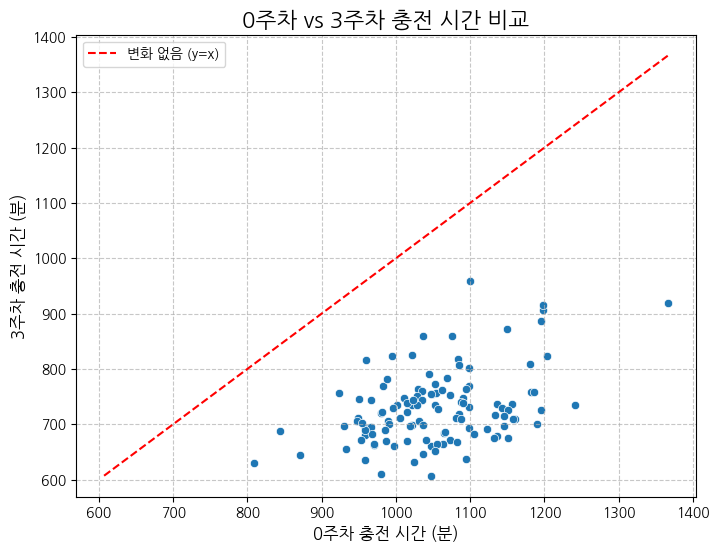

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm -rf ~/.cache/matplotlib # Matplotlib 캐시 삭제 (필수!)
plt.rcParams['font.family'] = 'NanumGothic'

# 윈도우 환경(맑은 고딕)

# 마이너스 부호 깨짐 방지
plt.rcParams['axes.unicode_minus'] = False


plt.figure(figsize=(8, 6)) # 그래프의 크기를 설정 (가로 8인치, 세로 6인치)

# 산점도 그리기
# x축: 0주차에서 특정 레벨까지 충전되는 데 걸리는 시간
# y축: 3주차에서 특정 레벨까지 충전되는 데 걸리는 시간
sns.scatterplot(x='CV_time_0', y='CV_time_3', data=train_df)

# 대각선 (y=x) 추가: 둘의 시간이 같다면 점이 대각선 위에 있을 것입니다.
plt.plot([min(train_df['CV_time_0'].min(), train_df['CV_time_3'].min()),
          max(train_df['CV_time_0'].max(), train_df['CV_time_3'].max())],# X축에 찍을 두 점의 좌표
         [min(train_df['CV_time_0'].min(), train_df['CV_time_3'].min()), # y축에 찍을 두 점의 좌표
          max(train_df['CV_time_0'].max(), train_df['CV_time_3'].max())],
         color='red', linestyle='--', label='변화 없음 (y=x)')

# 그래프 제목과 축 라벨 설정
plt.title('0주차 vs 3주차 충전 시간 비교', fontsize=16)
plt.xlabel('0주차 충전 시간 (분)', fontsize=12)
plt.ylabel('3주차 충전 시간 (분)', fontsize=12)

# 그리드(격자) 추가하여 값 확인 용이하게
plt.grid(True, linestyle='--', alpha=0.7)

# 범례 표시 (대각선 라벨을 보여주기 위해)
plt.legend()

# 그래프 보여주기
plt.show()

시간이 지남에 따라 충전시간이 늘어날 것이라고 생각했는데 산점도의 결과를 보니 시간이 지남에 따라 충전시간이 감소했습니다.

그렇다면 Lifetime과 충전시간의 관계는 어떤지 한번 확인해보겠습니다.

2. Lifetime vs 충전 시간 변화량

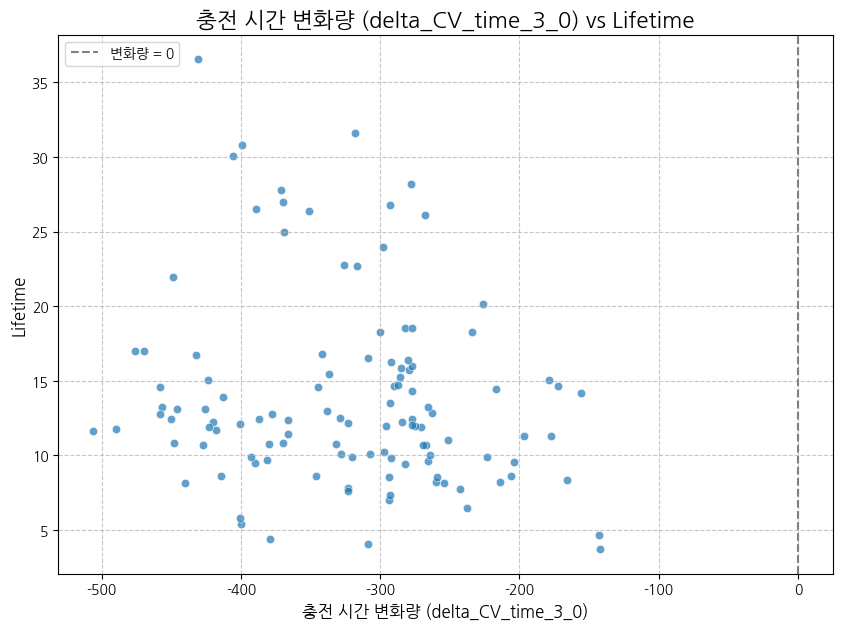


'delta_CV_time_3_0'과 'Lifetime' 간의 상관계수: -0.18


In [10]:
plt.figure(figsize=(10, 7)) # 그래프 크기 설정

# 산점도 그리기
# X축: delta_CV_time_3_0
# Y축: Lifetime
sns.scatterplot(x='delta_CV_time_3_0', y='Lifetime', data=train_df, alpha=0.7) # alpha로 투명도 설정 (점이 많을 때 유용)

# 그래프 제목과 축 라벨 설정
plt.title('충전 시간 변화량 (delta_CV_time_3_0) vs Lifetime', fontsize=16)
plt.xlabel('충전 시간 변화량 (delta_CV_time_3_0)', fontsize=12) # 컬럼의 실제 의미에 맞춰 라벨 조정 필요
plt.ylabel('Lifetime', fontsize=12)

# X축 0에 수직선 추가: 변화량이 0인 지점 (0주차와 3주차 시간이 같을 때)
plt.axvline(x=0, color='grey', linestyle='--', label='변화량 = 0')

# 그리드(격자) 추가
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend() # 범례 표시

# 그래프 보여주기
plt.show()

# 3. 추가적으로 'delta_CV_time_3_0'와 'Lifetime' 간의 상관계수도 확인
correlation_delta_lifetime = train_df['delta_CV_time_3_0'].corr(train_df['Lifetime'])
print(f"\n'delta_CV_time_3_0'과 'Lifetime' 간의 상관계수: {correlation_delta_lifetime:.2f}")

상관관계가 매우 약한 것으로 보입니다. 
그럼 이건 
1. 두 변수 사이의 관계가 없거나
2. 비선형적인 관계가 있거나 
인 것 같습니다.

비선형적인 관계가 있는지 확인해봅니다.

delta_CV_time_3_0 기술통계:
count    116.000000
mean    -323.491379
std       82.668904
min     -506.000000
25%     -389.250000
50%     -309.000000
75%     -274.000000
max     -142.000000
Name: delta_CV_time_3_0, dtype: float64

delta_CV_time_3_0 최소값: -506.0
delta_CV_time_3_0 최대값: -142.0


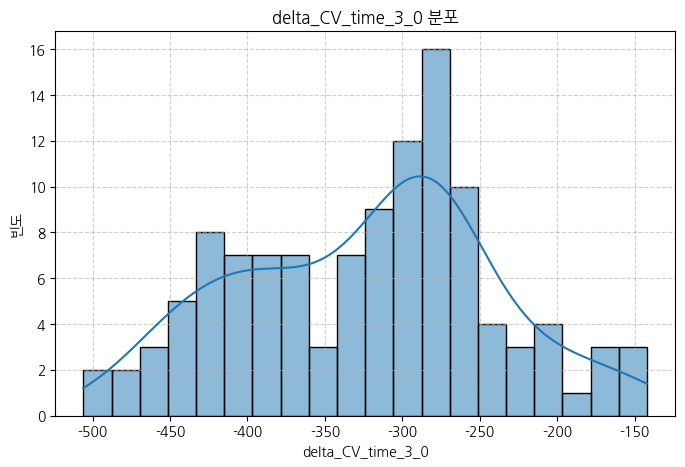

In [11]:
# --- 1. 'delta_CV_time_3_0' 컬럼의 분포 확인 (구간 설정을 위해) ---
print(f"delta_CV_time_3_0 기술통계:\n{train_df['delta_CV_time_3_0'].describe()}")
print(f"\ndelta_CV_time_3_0 최소값: {train_df['delta_CV_time_3_0'].min()}")
print(f"delta_CV_time_3_0 최대값: {train_df['delta_CV_time_3_0'].max()}")

# 히스토그램으로 분포 시각화 (구간 나누기 전 참고용)
plt.figure(figsize=(8, 5))
sns.histplot(train_df['delta_CV_time_3_0'], kde=True, bins=20)
plt.title('delta_CV_time_3_0 분포')
plt.xlabel('delta_CV_time_3_0')
plt.ylabel('빈도')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

그래프의 빈도가 일정하지 않고 들쭉날쭉합니다. 
그러니까 상관성이 없는 게 아니라 단지 비선형적인 패턴이기 때문에 상관계수가 낮게 나왔다고 생각해볼 수 있습니다.

데이터를 의미있는 덩어리로 나눠 Lifetime에 어떤 영향을 미치는지 세분화하여 탐색하기 위해서 구간을 나누겠습니다. 

In [12]:
# 데이터의 분위수에 따라 4개 구간으로 나누기
train_df['delta_CV_time_3_0_bin'] = pd.qcut(train_df['delta_CV_time_3_0'], q=4,
                                       labels=['Q1 (가장 많이 단축)', 'Q2(많이 단축)', 'Q3(적당히 단축)', 'Q4 (가장 적게 단축)'],
                                       duplicates='drop') # 중복 경계값 처리


print("\n--- 'delta_CV_time_3_0' 구간별 데이터 개수 ---")
print(train_df['delta_CV_time_3_0_bin'].value_counts().sort_index())


--- 'delta_CV_time_3_0' 구간별 데이터 개수 ---
delta_CV_time_3_0_bin
Q1 (가장 많이 단축)    29
Q2(많이 단축)        30
Q3(적당히 단축)       28
Q4 (가장 적게 단축)    29
Name: count, dtype: int64


/tmp/ipykernel_312/2292075991.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='delta_CV_time_3_0_bin', y='Lifetime', data=train_df, palette='viridis')


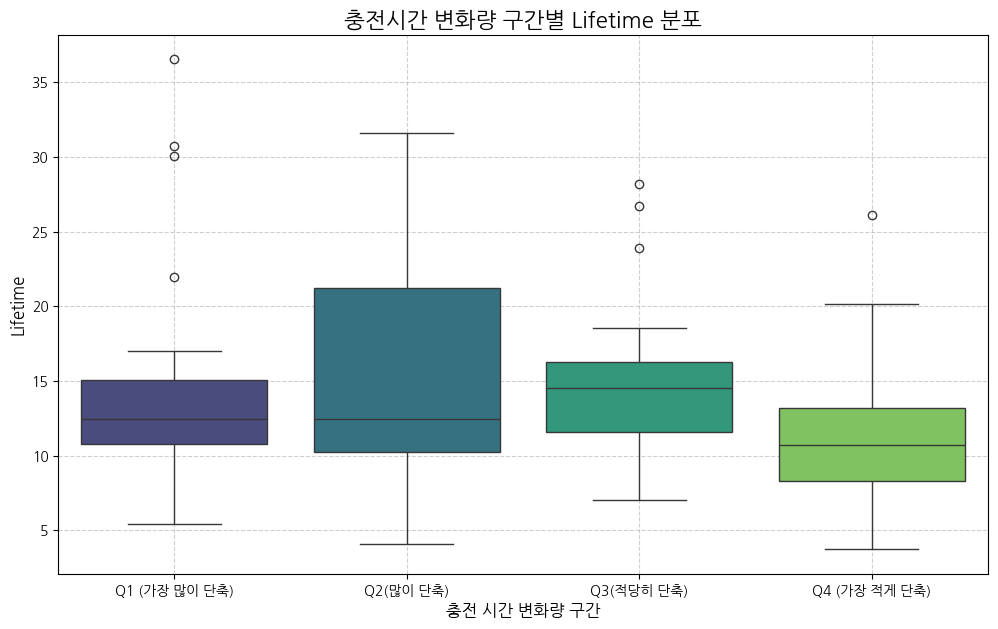


--- 충전시간 변화량 구간별 Lifetime 통계 ---
                            mean  median       std
delta_CV_time_3_0_bin                             
Q1 (가장 많이 단축)          14.430621  12.436  7.144017
Q2(많이 단축)              15.140267  12.473  7.488215
Q3(적당히 단축)             14.643357  14.506  5.242018
Q4 (가장 적게 단축)          11.299759  10.717  4.609466


/tmp/ipykernel_312/2292075991.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(train_df.groupby('delta_CV_time_3_0_bin')['Lifetime'].agg(['mean', 'median', 'std']))


In [13]:

# --- 3. 구간별 'Lifetime' 박스플롯 그리기 ---
plt.figure(figsize=(12, 7))

sns.boxplot(x='delta_CV_time_3_0_bin', y='Lifetime', data=train_df, palette='viridis')

plt.title('충전시간 변화량 구간별 Lifetime 분포', fontsize=16)
plt.xlabel('충전 시간 변화량 구간', fontsize=12)
plt.ylabel('Lifetime', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# --- 4. (선택) 구간별 Lifetime 평균/중앙값 확인 ---
print("\n--- 충전시간 변화량 구간별 Lifetime 통계 ---")
print(train_df.groupby('delta_CV_time_3_0_bin')['Lifetime'].agg(['mean', 'median', 'std']))

delta_CV_time_3_0과 Lifetime은 선형적인 관계는 아니지만, Q3에서 Lifetime에 유의미한 영향을 미치고 있다고 볼 수 있습니다.

즉, 충전 시간이 너무 많이 줄어드는 것도(Q1), 너무 적게 줄어드는 것도(Q4) 수명에는 부정적이거나 덜 긍정적이고, '적당히 단축'되는 것이 가장 긴 수명과 연관되어 있다는 가설을 세울 수 있습니다.

Q2 그룹은 평균은 높지만 중앙값은 Q3보다 낮은데, 이는 Q2 그룹에 매우 높은 Lifetime을 가진 몇몇 배터리 셀(이상치)이 존재하여 평균을 높였을 가능성을 시사해. 이 이상치들을 추가로 분석해보면 흥미로운 패턴을 발견할 수도 있어.

In [17]:
# --- ✨ 4. Q2 그룹 데이터 필터링 및 Lifetime 확인 ✨ ---
# Q2 그룹의 데이터만 추출
q2_group_df = train_df[train_df['delta_CV_time_3_0_bin'] == 'Q2 (많이 단축)']

# Lifetime 값을 내림차순으로 정렬하여 상위 10개 확인
print(f"\n--- Q2 (많이 단축) 그룹의 Lifetime 상위 10개 값 ---")
print(q2_group_df['Lifetime'].nlargest(10))

# Q2 그룹의 Lifetime에 대한 기술통계량 다시 확인
print(f"\n--- Q2 (많이 단축) 그룹의 Lifetime 기술통계 ---")
print(q2_group_df['Lifetime'].describe())

# (선택 사항) Q2 그룹의 Lifetime이 이상치 기준을 벗어나는지 확인
if not q2_group_df.empty: # q2_group_df가 비어있지 않은 경우에만 계산
    Q1_lifetime = q2_group_df['Lifetime'].quantile(0.25)
    Q3_lifetime = q2_group_df['Lifetime'].quantile(0.75)
    IQR_lifetime = Q3_lifetime - Q1_lifetime
    upper_bound = Q3_lifetime + 1.5 * IQR_lifetime

    print(f"\n--- Q2 (많이 단축) 그룹에서 Lifetime이 이상치 기준 ({upper_bound:.2f}) 이상인 데이터 ---")
    outliers_q2 = q2_group_df[q2_group_df['Lifetime'] > upper_bound][['delta_CV_time_3_0', 'Lifetime']].sort_values(by='Lifetime', ascending=False)
    if not outliers_q2.empty:
        print(outliers_q2)
    else:
        print("Q2 그룹에 통계적 이상치로 판단되는 높은 Lifetime 데이터는 없습니다.")
else:
    print("\nQ2 (많이 단축) 그룹에 데이터가 없어 이상치 분석을 수행할 수 없습니다.")



--- Q2 (많이 단축) 그룹의 Lifetime 상위 10개 값 ---
Cell_ID
8867G    31.609
3642L    27.751
5979W    26.960
3277K    26.505
6427K    26.341
4581C    24.956
8313K    22.779
3347H    22.681
1101F    16.805
1542K    16.526
Name: Lifetime, dtype: float64

--- Q2 (많이 단축) 그룹의 Lifetime 기술통계 ---
count    30.000000
mean     15.140267
std       7.488215
min       4.047000
25%      10.269500
50%      12.473000
75%      21.212000
max      31.609000
Name: Lifetime, dtype: float64

--- Q2 (많이 단축) 그룹에서 Lifetime이 이상치 기준 (37.63) 이상인 데이터 ---
Q2 그룹에 통계적 이상치로 판단되는 높은 Lifetime 데이터는 없습니다.


Q2 그룹에는 수명이 낮은 배터리도 있고, 높은 배터리도 있다는 걸 확인할  수 있었습니다.

3. Lifetime vs Chg C-rate/Dchg C-rate
배터리의 충전율(Chg_C-rate)과 방전율(Dchg_C-rate)이 배터리 수명(Lifetime)에 영향을 미칠 것이라고 예상했습니다. 

이에 따라 초기 분석으로 각 C-rate 변수와 Lifetime 간의 선형적 상관관계를 확인했습니다. 

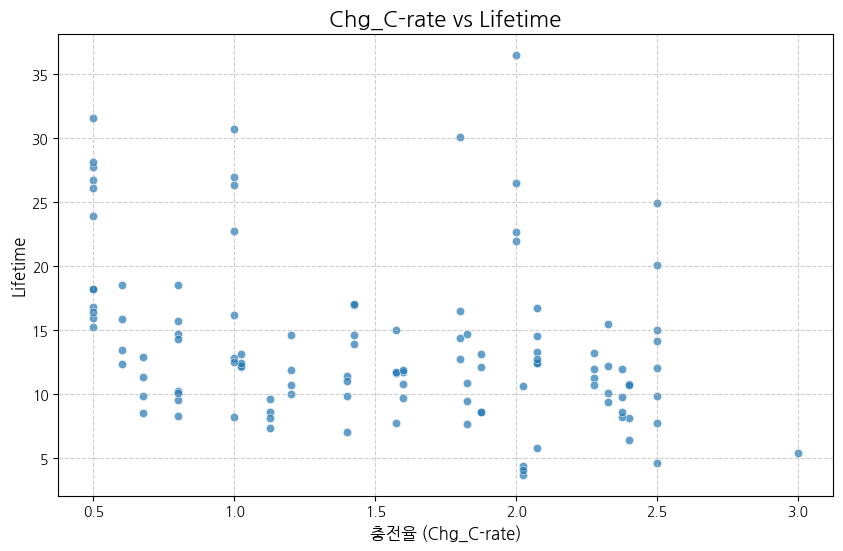

Chg_C-rate와 Lifetime 간의 상관계수: -0.31



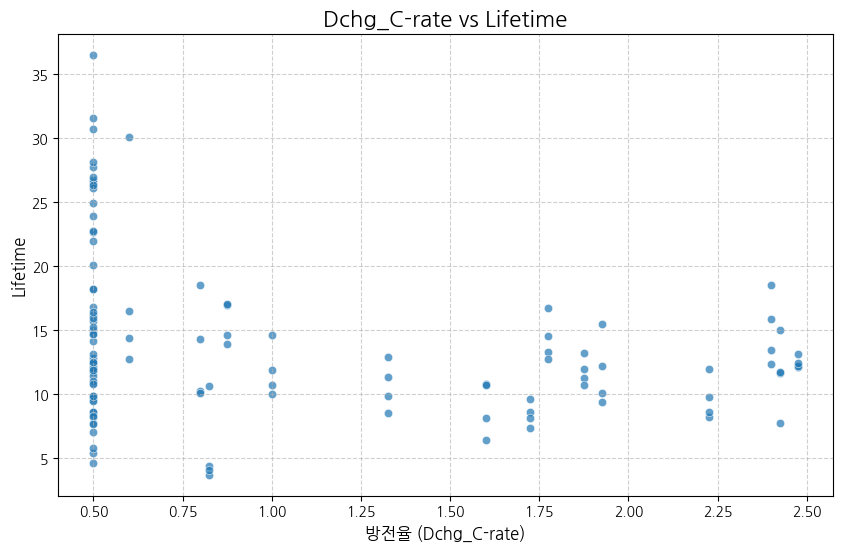

Dchg_C-rate와 Lifetime 간의 상관계수: -0.27


In [18]:
# --- 1. Chg_C-rate와 Lifetime 간의 산점도 및 상관계수 ---
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Chg_C-rate', y='Lifetime', data=train_df, alpha=0.7)
plt.title('Chg_C-rate vs Lifetime', fontsize=16)
plt.xlabel('충전율 (Chg_C-rate)', fontsize=12)
plt.ylabel('Lifetime', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

correlation_chg = train_df['Chg_C-rate'].corr(train_df['Lifetime'])
print(f"Chg_C-rate와 Lifetime 간의 상관계수: {correlation_chg:.2f}\n")


# --- 2. Dchg_C-rate와 Lifetime 간의 산점도 및 상관계수 ---
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Dchg_C-rate', y='Lifetime', data=train_df, alpha=0.7)
plt.title('Dchg_C-rate vs Lifetime', fontsize=16)
plt.xlabel('방전율 (Dchg_C-rate)', fontsize=12)
plt.ylabel('Lifetime', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

correlation_dchg = train_df['Dchg_C-rate'].corr(train_df['Lifetime'])
print(f"Dchg_C-rate와 Lifetime 간의 상관계수: {correlation_dchg:.2f}")

하지만 예상과는 달리, Chg_C-rate와 Dchg_C-rate 각각은 Lifetime과 낮은 상관계수를 보이는 것으로 나타났습니다. 이는 단순히 개별 충전율이나 방전율만으로는 Lifetime과의 직접적인 선형 관계를 설명하기 어렵다는 것을 의미했습니다.

이에 배터리에 가해지는 복합적인 요인이 Lifetime에 영향을 미칠 수 있다는 가설을 세웠습니다. 배터리 수명은 단순히 얼마나 빨리 충전되고 방전되는가보다는, 그 과정에서 배터리 셀이 받는 누적된 부담과 더 깊은 연관이 있을 것이라고 판단했습니다.

데이터셋의 컬럼 목록을 재검토하던 중, 이러한 가설과 부합하는 chg_stress와 dchg_stress 컬럼 및 이 둘을 곱한 multi_stress 컬럼의 존재를 확인했습니다. 이 stress 컬럼들이 C-rate와 밀접한 관련이 있을 것이라고 추정하고, 우선적으로 chg_stress와 Chg_C-rate, dchg_stress와 Dchg_C-rate 간의 관계를 확인했습니다. 

Chg_C-rate와 chg_stress 간의 상관계수: 0.83

Dchg_C-rate와 dchg_stress 간의 상관계수: 0.92



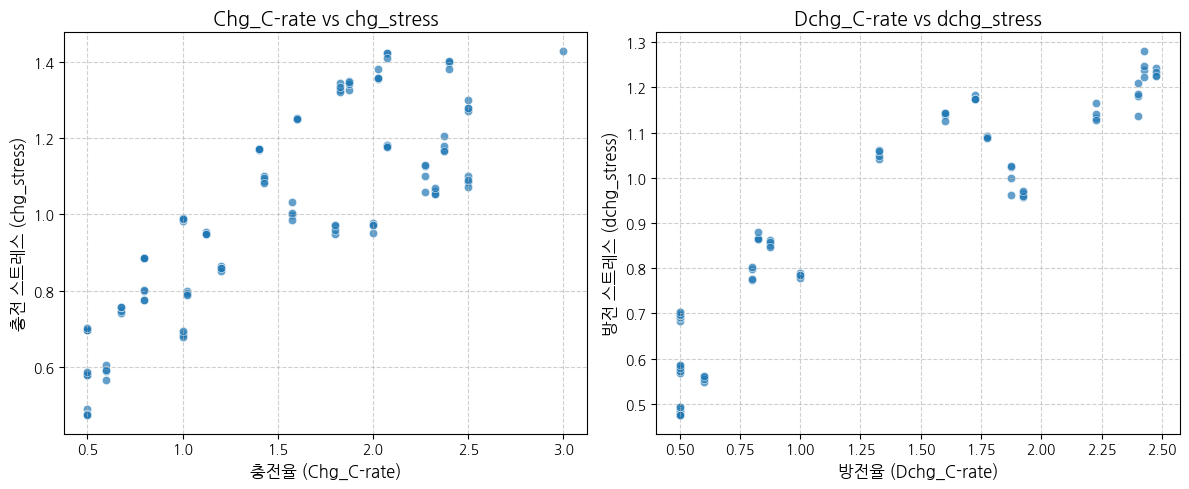

In [19]:
# --- 1. Chg_C-rate와 chg_stress 간의 상관관계 및 산점도 ---
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1) # 1행 2열 중 첫 번째 플롯
sns.scatterplot(x='Chg_C-rate', y='chg_stress', data=train_df, alpha=0.7)
plt.title('Chg_C-rate vs chg_stress', fontsize=14)
plt.xlabel('충전율 (Chg_C-rate)', fontsize=12)
plt.ylabel('충전 스트레스 (chg_stress)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)

correlation_chg_stress = train_df['Chg_C-rate'].corr(train_df['chg_stress'])
print(f"Chg_C-rate와 chg_stress 간의 상관계수: {correlation_chg_stress:.2f}\n")


# --- 2. Dchg_C-rate와 dchg_stress 간의 상관관계 및 산점도 ---
plt.subplot(1, 2, 2) # 1행 2열 중 두 번째 플롯
sns.scatterplot(x='Dchg_C-rate', y='dchg_stress', data=train_df, alpha=0.7)
plt.title('Dchg_C-rate vs dchg_stress', fontsize=14)
plt.xlabel('방전율 (Dchg_C-rate)', fontsize=12)
plt.ylabel('방전 스트레스 (dchg_stress)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)

correlation_dchg_stress = train_df['Dchg_C-rate'].corr(train_df['dchg_stress'])
print(f"Dchg_C-rate와 dchg_stress 간의 상관계수: {correlation_dchg_stress:.2f}\n")

plt.tight_layout() # 그래프 간 간격 자동 조절
plt.show()


분석 결과, Chg_C-rate와 chg_stress는 0.83의 높은 상관계수를, Dchg_C-rate와 dchg_stress는 0.92의 매우 높은 상관계수를 보이며 강력한 양의 선형 관계를 가지고 있음을 확인했습니다.

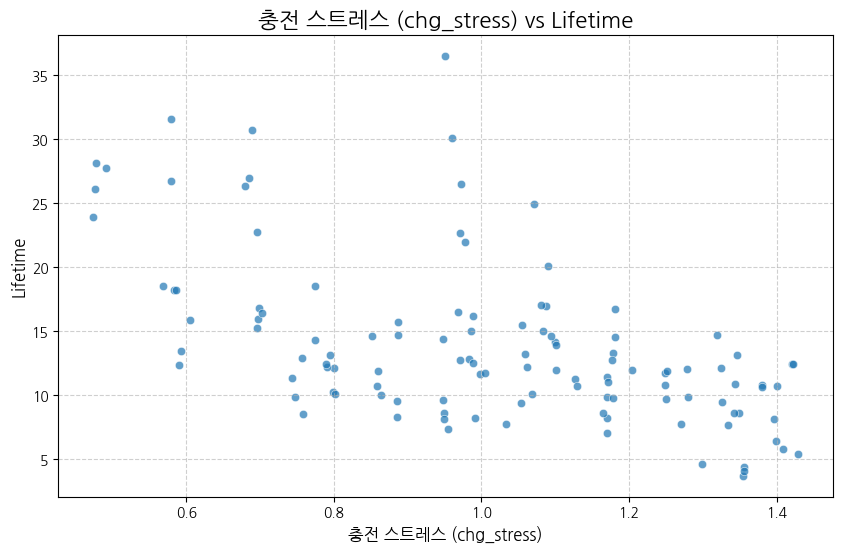

chg_stress와 Lifetime 간의 상관계수: -0.57



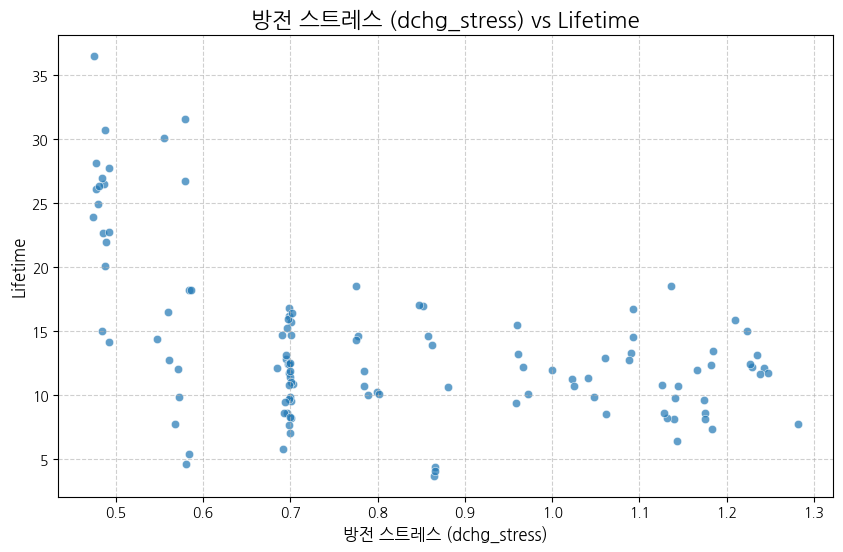

dchg_stress와 Lifetime 간의 상관계수: -0.48


In [20]:
# --- 1. chg_stress와 Lifetime 간의 산점도 및 상관계수 ---
plt.figure(figsize=(10, 6))
sns.scatterplot(x='chg_stress', y='Lifetime', data=train_df, alpha=0.7)
plt.title('충전 스트레스 (chg_stress) vs Lifetime', fontsize=16)
plt.xlabel('충전 스트레스 (chg_stress)', fontsize=12)
plt.ylabel('Lifetime', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

correlation_chg_stress_lifetime = train_df['chg_stress'].corr(train_df['Lifetime'])
print(f"chg_stress와 Lifetime 간의 상관계수: {correlation_chg_stress_lifetime:.2f}\n")


# --- 2. dchg_stress와 Lifetime 간의 산점도 및 상관계수 ---
plt.figure(figsize=(10, 6))
sns.scatterplot(x='dchg_stress', y='Lifetime', data=train_df, alpha=0.7)
plt.title('방전 스트레스 (dchg_stress) vs Lifetime', fontsize=16)
plt.xlabel('방전 스트레스 (dchg_stress)', fontsize=12)
plt.ylabel('Lifetime', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

correlation_dchg_stress_lifetime = train_df['dchg_stress'].corr(train_df['Lifetime'])
print(f"dchg_stress와 Lifetime 간의 상관계수: {correlation_dchg_stress_lifetime:.2f}")


더욱이, chg_stress(-0.51)와 dchg_stress(-0.48)는 Lifetime과 중간 수준의 음의 상관관계를 보였습니다. 이는 개별 C-rate 변수가 Lifetime과 낮은 상관관계를 보였던 것과 대조적인 결과입니다. 이러한 결과는 chg_stress와 dchg_stress가 단순히 C-rate의 선형적 변환이 아니라, **C-rate를 포함하여 배터리에 가해지는 다양한 물리적/화학적 부담을 종합적으로 반영하는, Lifetime과 더 밀접하게 관련된 '종합적인 스트레스 지표'**임을 강력하게 시사합니다. 즉, 이 스트레스 지수가 높을수록 배터리 수명이 감소하는 경향이 있음을 파악했습니다.

chg_stress와 DoD 간의 상관계수: 0.38

dchg_stress와 DoD 간의 상관계수: 0.02



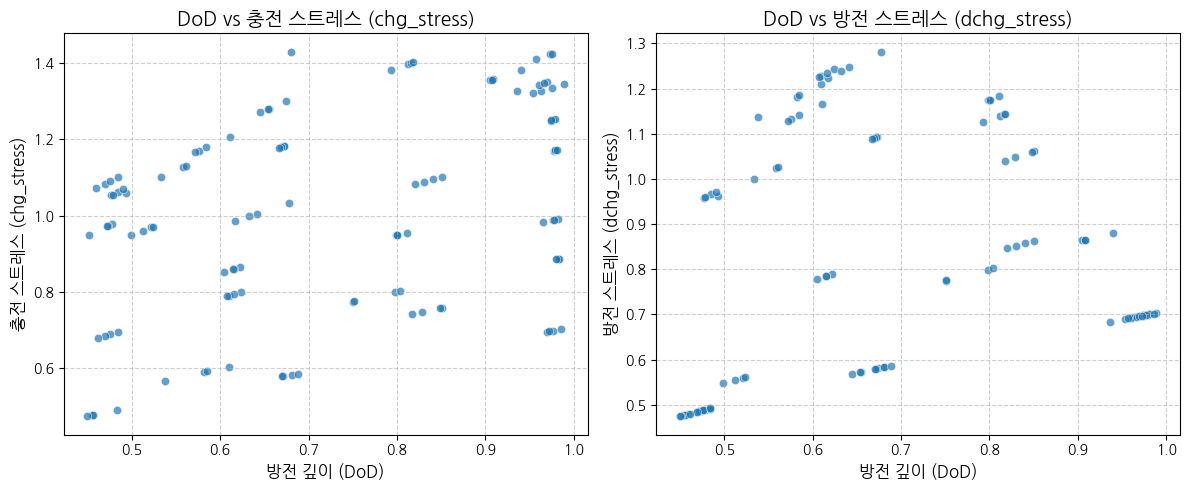

In [21]:
# --- 1. chg_stress와 DoD 간의 산점도 및 상관계수 ---
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1) # 1행 2열 중 첫 번째 플롯
sns.scatterplot(x='DoD', y='chg_stress', data=train_df, alpha=0.7)
plt.title('DoD vs 충전 스트레스 (chg_stress)', fontsize=14)
plt.xlabel('방전 깊이 (DoD)', fontsize=12)
plt.ylabel('충전 스트레스 (chg_stress)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)

correlation_chg_stress_dod = train_df['chg_stress'].corr(train_df['DoD'])
print(f"chg_stress와 DoD 간의 상관계수: {correlation_chg_stress_dod:.2f}\n")


# --- 2. dchg_stress와 DoD 간의 산점도 및 상관계수 ---
plt.subplot(1, 2, 2) # 1행 2열 중 두 번째 플롯
sns.scatterplot(x='DoD', y='dchg_stress', data=train_df, alpha=0.7)
plt.title('DoD vs 방전 스트레스 (dchg_stress)', fontsize=14)
plt.xlabel('방전 깊이 (DoD)', fontsize=12)
plt.ylabel('방전 스트레스 (dchg_stress)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)

correlation_dchg_stress_dod = train_df['dchg_stress'].corr(train_df['DoD'])
print(f"dchg_stress와 DoD 간의 상관계수: {correlation_dchg_stress_dod:.2f}\n")

plt.tight_layout() # 그래프 간 간격 자동 조절
plt.show()

In [ ]:
DoD라서 방전 스트레스와 좀 더 연관이 잇을 거라고 생각했는데 방전스트레스에서 상관관계가 훨씬 떨어졌다. 
예를 들어, dchg_stress는 방전 깊이(DoD)보다는 순간적인 방전 속도의 변화, 전압 강하의 급격성, 또는 특정 전압 구간에서의 불안정성(dQdV 관련 특성) 등에 더 큰 가중치를 두고 계산되었을 수 있음.
비선형적인 관계는 아닌지 확인해보자 

/tmp/ipykernel_312/1516214230.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='dchg_stress_bin', y='DoD', data=train_df, palette='plasma')


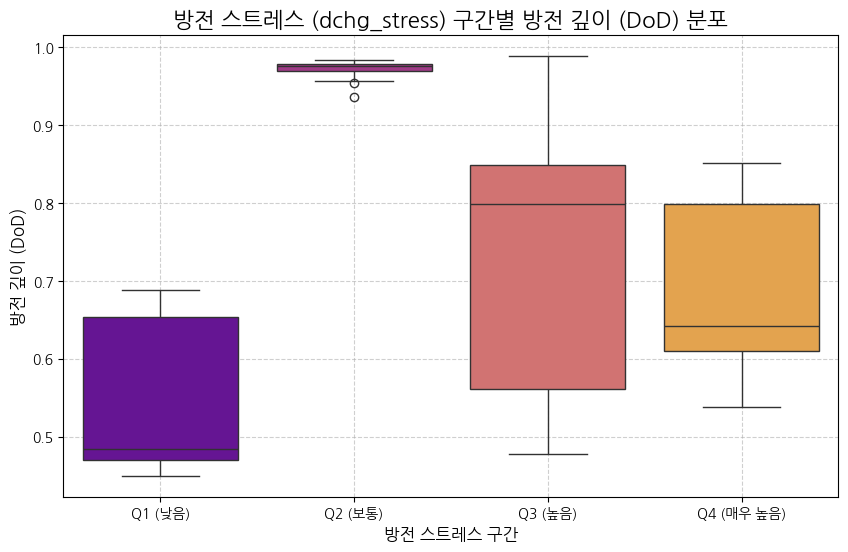


--- 방전 스트레스 (dchg_stress) 구간별 DoD 기술통계 ---
                 count      mean       std       min       25%       50%  \
dchg_stress_bin                                                            
Q1 (낮음)           29.0  0.537039  0.092087  0.449769  0.469692  0.483927   
Q2 (보통)           29.0  0.972316  0.010316  0.936112  0.969660  0.975688   
Q3 (높음)           29.0  0.727939  0.169997  0.477084  0.560898  0.798062   
Q4 (매우 높음)        29.0  0.678036  0.096920  0.537660  0.609588  0.641347   

                      75%       max  
dchg_stress_bin                      
Q1 (낮음)          0.653736  0.688216  
Q2 (보통)          0.978500  0.983277  
Q3 (높음)          0.848620  0.988713  
Q4 (매우 높음)       0.798693  0.850636  


/tmp/ipykernel_312/1516214230.py:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(train_df.groupby('dchg_stress_bin')['DoD'].describe())


In [23]:
# --- 2. dchg_stress를 4개의 구간으로 나누고 DoD 분포 확인 ---
# qcut을 사용하여 dchg_stress를 4분위수로 나눔
train_df['dchg_stress_bin'] = pd.qcut(train_df['dchg_stress'], q=4,
                                   labels=['Q1 (낮음)', 'Q2 (보통)', 'Q3 (높음)', 'Q4 (매우 높음)'],
                                   duplicates='drop')

plt.figure(figsize=(10, 6))
sns.boxplot(x='dchg_stress_bin', y='DoD', data=train_df, palette='plasma')
plt.title('방전 스트레스 (dchg_stress) 구간별 방전 깊이 (DoD) 분포', fontsize=16)
plt.xlabel('방전 스트레스 구간', fontsize=12)
plt.ylabel('방전 깊이 (DoD)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# 각 구간별 DoD의 기술통계 확인
print("\n--- 방전 스트레스 (dchg_stress) 구간별 DoD 기술통계 ---")
print(train_df.groupby('dchg_stress_bin')['DoD'].describe())

이 박스플롯을 통해 dchg_stress와 DoD 사이에 선형적인 관계가 없음이 다시 한번 명확하게 확인돼. dchg_stress가 증가한다고 DoD가 계속 증가하거나 감소하는 일관된 추세가 없거든.

심지어 Q2에서 DoD가 가장 높았다가 Q3, Q4에서 다시 낮아지는 것은, 단순한 비선형 관계라고 보기에도 다소 복잡하거나 일관되지 않은 패턴이야.

dchg_stress는 DoD를 주로 반영하지 않는다:

네가 처음 의문을 가졌던 "왜 방전 스트레스가 DoD와 관계가 낮을까?"에 대한 답은 더욱 명확해졌어. dchg_stress는 방전 깊이(DoD)를 주요하게 반영하여 계산된 스트레스 지표가 아닐 가능성이 매우 높아.



chg_stress와 var_deltaQ 간의 상관계수: 0.62

dchg_stress와 var_deltaQ_dchg_3_0 간의 상관계수: 0.11



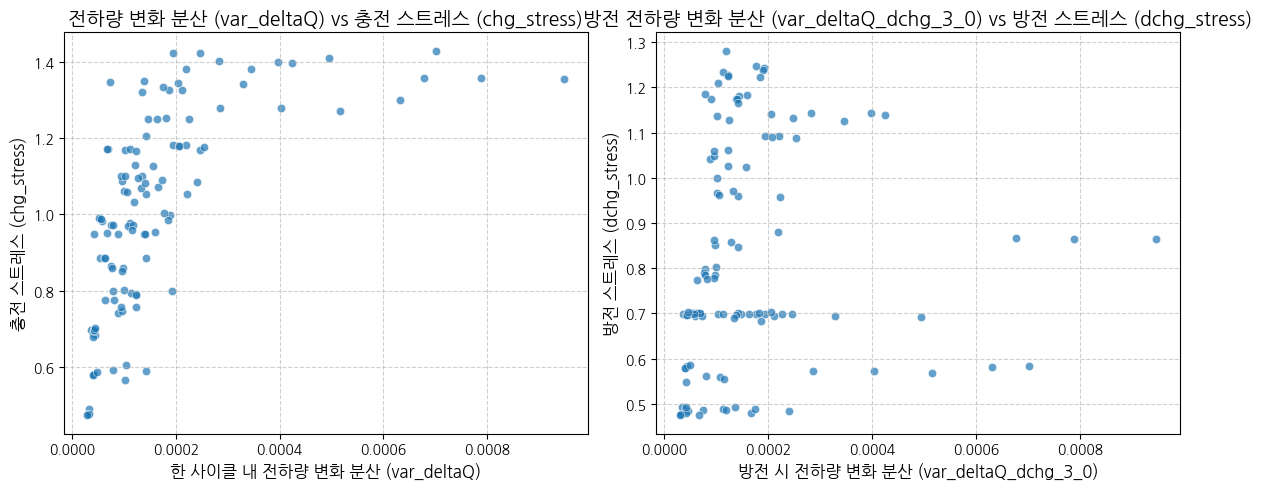

In [24]:
# --- 1. chg_stress와 var_deltaQ 간의 산점도 및 상관계수 ---
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1) # 1행 2열 중 첫 번째 플롯
sns.scatterplot(x='var_deltaQ', y='chg_stress', data=train_df, alpha=0.7)
plt.title('전하량 변화 분산 (var_deltaQ) vs 충전 스트레스 (chg_stress)', fontsize=14)
plt.xlabel('한 사이클 내 전하량 변화 분산 (var_deltaQ)', fontsize=12)
plt.ylabel('충전 스트레스 (chg_stress)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)

correlation_chg_stress_var_deltaQ = train_df['chg_stress'].corr(train_df['var_deltaQ'])
print(f"chg_stress와 var_deltaQ 간의 상관계수: {correlation_chg_stress_var_deltaQ:.2f}\n")


# --- 2. dchg_stress와 var_deltaQ_dchg_3_0 간의 산점도 및 상관계수 ---
plt.subplot(1, 2, 2) # 1행 2열 중 두 번째 플롯
sns.scatterplot(x='var_deltaQ_dchg_3_0', y='dchg_stress', data=train_df, alpha=0.7)
plt.title('방전 전하량 변화 분산 (var_deltaQ_dchg_3_0) vs 방전 스트레스 (dchg_stress)', fontsize=14)
plt.xlabel('방전 시 전하량 변화 분산 (var_deltaQ_dchg_3_0)', fontsize=12)
plt.ylabel('방전 스트레스 (dchg_stress)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)

correlation_dchg_stress_var_deltaQ_dchg = train_df['dchg_stress'].corr(train_df['var_deltaQ_dchg_3_0'])
print(f"dchg_stress와 var_deltaQ_dchg_3_0 간의 상관계수: {correlation_dchg_stress_var_deltaQ_dchg:.2f}\n")

plt.tight_layout() # 그래프 간 간격 자동 조절
plt.show()


dchg_stress와 mean_dqdv_dchg_3_0 간의 상관계수: 0.18

dchg_stress와 var_dqdv_dchg_3_0 간의 상관계수: 0.15



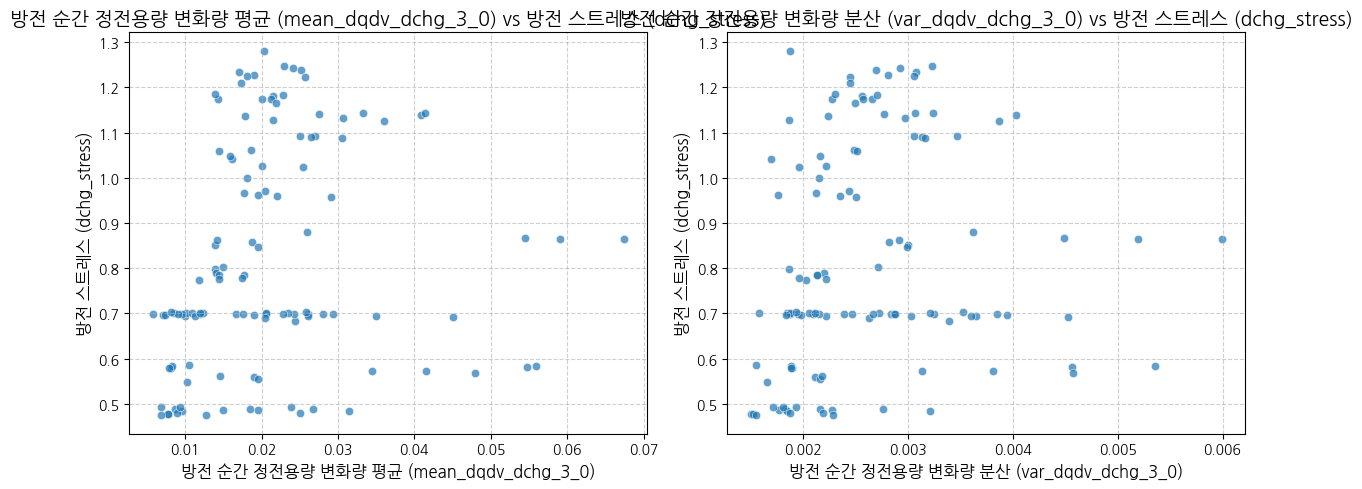

In [25]:
# --- 1. dchg_stress와 mean_dqdv_dchg_3_0 간의 산점도 및 상관계수 ---
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1) # 1행 2열 중 첫 번째 플롯
sns.scatterplot(x='mean_dqdv_dchg_3_0', y='dchg_stress', data=train_df, alpha=0.7)
plt.title('방전 순간 정전용량 변화량 평균 (mean_dqdv_dchg_3_0) vs 방전 스트레스 (dchg_stress)', fontsize=14)
plt.xlabel('방전 순간 정전용량 변화량 평균 (mean_dqdv_dchg_3_0)', fontsize=12)
plt.ylabel('방전 스트레스 (dchg_stress)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)

correlation_dchg_stress_mean_dqdv = train_df['dchg_stress'].corr(train_df['mean_dqdv_dchg_3_0'])
print(f"dchg_stress와 mean_dqdv_dchg_3_0 간의 상관계수: {correlation_dchg_stress_mean_dqdv:.2f}\n")


# --- 2. dchg_stress와 var_dqdv_dchg_3_0 간의 산점도 및 상관계수 ---
plt.subplot(1, 2, 2) # 1행 2열 중 두 번째 플롯
sns.scatterplot(x='var_dqdv_dchg_3_0', y='dchg_stress', data=train_df, alpha=0.7)
plt.title('방전 순간 정전용량 변화량 분산 (var_dqdv_dchg_3_0) vs 방전 스트레스 (dchg_stress)', fontsize=14)
plt.xlabel('방전 순간 정전용량 변화량 분산 (var_dqdv_dchg_3_0)', fontsize=12)
plt.ylabel('방전 스트레스 (dchg_stress)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)

correlation_dchg_stress_var_dqdv = train_df['dchg_stress'].corr(train_df['var_dqdv_dchg_3_0'])
print(f"dchg_stress와 var_dqdv_dchg_3_0 간의 상관계수: {correlation_dchg_stress_var_dqdv:.2f}\n")

plt.tight_layout() # 그래프 간 간격 자동 조절
plt.show()

In [15]:
# index의 정보를 확인합니다.
train_df.index

Index(['1031U', '1101F', '1138K', '1179M', '1240W', '1303Y', '1397U', '1441V',
       '1454Q', '1513R',
       ...
       '9067Q', '9090C', '9108V', '9349O', '9373N', '9627Y', '9833F', '9835L',
       '9897W', '9908R'],
      dtype='object', name='Cell_ID', length=116)


# ------------------------------------------------------------
불러온 평가용 데이터의 일부를 확인해봅시다.

In [ ]:
test_x.head()

In [ ]:
print("Train Data 크기 :", train_df.shape)
print("Test Data 크기 :", test_x.shape)

## 데이터 전처리

1. 결측치가 있는지 확인합니다.

In [ ]:
na_columns_train = train_x.columns[train_x.isna().any()]
na_columns_test = test_x.columns[test_x.isna().any()]
na_columns = set(na_columns_train) | set(na_columns_test)
na_columns

2. 데이터를 정규화 합니다.

In [ ]:
# 데이터 정규화

scaler = MinMaxScaler()
train_x_scaled = scaler.fit_transform(train_x)
test_x_scaled = scaler.transform(test_x)

In [ ]:
print("Train Data 크기 :", train_x.shape)
print("Test Data 크기 :", test_x.shape)

## 모델 학습

모델은 각자 자유롭게 구성할 수 있으며, 올바른 형식으로 `submission.csv`를 작성한다면 다양한 모델이 허용됩니다.

아래는 이해를 돕기 위한 예시 코드로, 간단한 서포트 벡터 머신 기반 회귀 예측 모델 (SVR) 을 사용합니다.

In [ ]:
model = SVR()
model.fit(train_x, train_y)

학습 데이터에 대한 성능을 확인합니다.

In [ ]:
pred_train = model.predict(train_x)
print("MAPE Score for Train: ", mean_absolute_percentage_error(train_y, pred_train))

## 모델 평가 및 결과 저장

회귀 모델을 평가하기 위한 지표는 다양하게 있으며, 저희는 그 중에서 **MAPE Score** 지표를 활용하여 순위를 결정할 것입니다.

여러분들이 작성하신 모델의 성능을 평가하기 위해서는, 지시사항에 나와 있는 대로 **테스트 데이터**를 불러와서 예측을 수행하고, 그 결과를 반드시 `submission.csv` 파일에 기록하여 제출해야 합니다.

In [ ]:
# 제출 템플릿을 불러옵니다.
submission = pd.read_csv("submission.csv", index_col=0)

# 테스트 데이터에 대한 예측 결과를 저장합니다.
# Note. 예시 코드에서는 index(Cell_ID)의 순서를 수정하지 않아서 예측 결과를 바로 템플릿에 할당했지만, 
# 만약 학습 과정에서 index를 수정하셨다면, sort_index() 등으로 index를 맞추는 것을 권장 드립니다.
submission["Lifetime"] = model.predict(test_x)
submission.to_csv("submission.csv")

### 결과 검증

`submission.csv` 파일을 다시 불러와 올바르게 값을 채웠는지 다시 한번 확인합니다.

In [ ]:
submission = pd.read_csv("submission.csv", index_col=0)
submission

### 제출

`submission.csv` 파일이 제대로 생성됐다면, 우측 상단의 제출 버튼을 눌러 `submission.csv` 파일을 제출하고 리더보드에서 점수를 확인하세요.

- 팀당 제출 가능 횟수는 **1일 20회** 입니다. 팀 내 모든 구성원이 제출 가능하나 팀 제출 횟수는 팀 단위로 합산됩니다.
- 최종 채점 기준: Private score 50% + Public score 50%
- 리더보드에는 **마지막으로 제출한 결과**의 Public 점수가 공개됩니다.
- 최종 채점에는 마지막으로 제출된 결과로 평가됩니다.

## 경진대회 종료 전 제출을 희망하는 코드와 결과물로 마지막 제출을 수행하세요.
## 반드시 마지막 제출된 프로젝트의 전체 파일을 압축하여 별도의 제출 공간에 제출하세요.

다음 파일들을 압축하여 별도의 제출공간에 제출해야 합니다.
- `code.ipynb`: 전체 프로젝트 진행 파일
- `submission.csv`: 예측 결과 파일
- 외부 데이터 사용 시: 원본 데이터 파일(혹은 데이터 다운로드 코드)
    - 외부 데이터에 대한 전처리 과정은 프로젝트 코드 내에 포함되어야 함
- 기타 프로젝트 실행에 필요한 모든 파일